In [1]:
import os
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import LeakyReLU, Input, Add
from keras import backend as K
import cv2
import numpy as np
import json
from __future__ import absolute_import
from __future__ import print_function
import itertools
from helper import *


DataPath = './CamVid/'
data_shape = 360,480


D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_data(mode):
    data = []
    label = []
    with open(DataPath + mode +'.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        label.append(one_hot_it(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
    return np.array(data), np.array(label)

train_data, train_label = load_data("train")
train_label = np.reshape(train_label,(367,360,480,12))


In [3]:
test_data, test_label = load_data("test")
test_label = np.reshape(test_label,(233,360,480,12))

In [4]:
val_data, val_label = load_data("val")
val_label = np.reshape(val_label,(101,360,480,12))

In [5]:
train_data = np.rollaxis(train_data[:,:,:,:], axis=3)
train_data = np.rollaxis(train_data[:,:,:,:], axis=3)
train_data = np.rollaxis(train_data[:,:,:,:], axis=2)

test_data = np.rollaxis(test_data[:,:,:,:], axis=3)
test_data = np.rollaxis(test_data[:,:,:,:], axis=3)
test_data = np.rollaxis(test_data[:,:,:,:], axis=2)

val_data = np.rollaxis(val_data[:,:,:,:], axis=3)
val_data = np.rollaxis(val_data[:,:,:,:], axis=3)
val_data = np.rollaxis(val_data[:,:,:,:], axis=2)

In [6]:
def SegnetGen(input, kernel, filter_size, pad, pool_size):
    
    Generator = input

    a = ZeroPadding2D(padding=(pad,pad))(Generator)
    conv1 = Convolution2D(filter_size, kernel, kernel, border_mode='valid')(a)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv1)
    conv1 = ZeroPadding2D(padding=(pad,pad))(conv1)
    conv2 = Convolution2D(128, kernel, kernel, border_mode='valid')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2p = MaxPooling2D(pool_size=(pool_size, pool_size))(conv2)
    conv2p = ZeroPadding2D(padding=(pad,pad))(conv2p)
    conv3 = Convolution2D(256, kernel, kernel, border_mode='valid')(conv2p)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3p = MaxPooling2D(pool_size=(pool_size, pool_size))(conv3)
    conv3p = ZeroPadding2D(padding=(pad,pad))(conv3p)
    conv4 = Convolution2D(512, kernel, kernel, border_mode='valid')(conv3p)
    conv4 = BatchNormalization()(conv4)
    Generator2 = LeakyReLU(alpha=0.2)(conv4)
    b = ZeroPadding2D(padding=(pad,pad))(Generator2)
    conv5 = Convolution2D(512, kernel, kernel, border_mode='valid')(b)
    conv5 = BatchNormalization()(conv5)
    conv5 = UpSampling2D(size=(pool_size,pool_size))(conv5)
    conv6 = ZeroPadding2D(padding=(pad,pad))(conv5)
    conv6 = Convolution2D(256, kernel, kernel, border_mode='valid')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = UpSampling2D(size=(pool_size,pool_size))(conv6)
    conv6 = ZeroPadding2D(padding=(pad,pad))(conv6) 
    conv7 = Convolution2D(128, kernel, kernel, border_mode='valid')(conv6)
    conv7 = BatchNormalization()(conv7)
    conv7 = UpSampling2D(size=(pool_size,pool_size))(conv7)
    conv8 = ZeroPadding2D(padding=(pad,pad))(conv7)
    conv8 = Convolution2D(filter_size, kernel, kernel, border_mode='valid')(conv8)
    conv8 = BatchNormalization()(conv8)
    Generator4 = (Convolution2D(12, 1, 1, border_mode='valid',))(conv8)  
    g_out = (Activation('softmax'))(Generator4)
    gen = Model(input = Generator, output = g_out)
    gen.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"]) 
    
    return gen, g_out



In [7]:
nb_epochs = 50
batch_size = 3
kernel = 3
filter_size = 64
pad = 1
pool_size = 2

d_input = Input(shape=(360,480,3))
G, d_out = SegnetGen(d_input, kernel, filter_size, pad, pool_size)
G.summary()


D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
  
D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
  # This is added back by InteractiveShellApp.init_path()
D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
  app.launch_new_instance()
D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
D:\Apps\Anaconda\envs\tensorflow\lib\s

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 360, 480, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 362, 482, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 360, 480, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 360, 480, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 240, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 182, 242, 64)      0         
__________

D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (1, 1), padding="valid")`
D:\Apps\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [8]:

history = G.fit(train_data, train_label, batch_size=batch_size, epochs = nb_epochs,
                    verbose=1,  validation_data=(test_data, test_label), shuffle=True) # validation_split=0.33

Train on 367 samples, validate on 233 samples
Epoch 1/50
367/367 [==============================] - 57s 155ms/step - loss: 1.2152 - acc: 0.6434 - val_loss: 2.5731 - val_acc: 0.5138
Epoch 2/50
367/367 [==============================] - 48s 130ms/step - loss: 0.9367 - acc: 0.7130 - val_loss: 1.7216 - val_acc: 0.5534
Epoch 3/50
367/367 [==============================] - 48s 130ms/step - loss: 0.8297 - acc: 0.7423 - val_loss: 1.9853 - val_acc: 0.5169
Epoch 4/50
367/367 [==============================] - 48s 131ms/step - loss: 0.7719 - acc: 0.7575 - val_loss: 1.0860 - val_acc: 0.6848
Epoch 5/50
367/367 [==============================] - 48s 130ms/step - loss: 0.7118 - acc: 0.7755 - val_loss: 1.2773 - val_acc: 0.6579
Epoch 6/50
367/367 [==============================] - 48s 130ms/step - loss: 0.6745 - acc: 0.7884 - val_loss: 1.1587 - val_acc: 0.6223
Epoch 7/50
367/367 [==============================] - 48s 130ms/step - loss: 0.6562 - acc: 0.7914 - val_loss: 0.9754 - val_acc: 0.7240
Epoch 8/5

In [14]:
train_label.shape

(367, 360, 480, 12)

In [178]:
from keras.models import load_model
import pickle

with open('C:/Users/JP/Documents/School/Deep Learning/SegNet/trainSEGHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
#G.save('SegNet1.h5')  # creates a HDF5 file 'my_model.h5'
#G = load_model('my_model.h5')
#G.save_weights('segNet1_Weights.h5')
#G.load_weights('my_model_weights.h5')

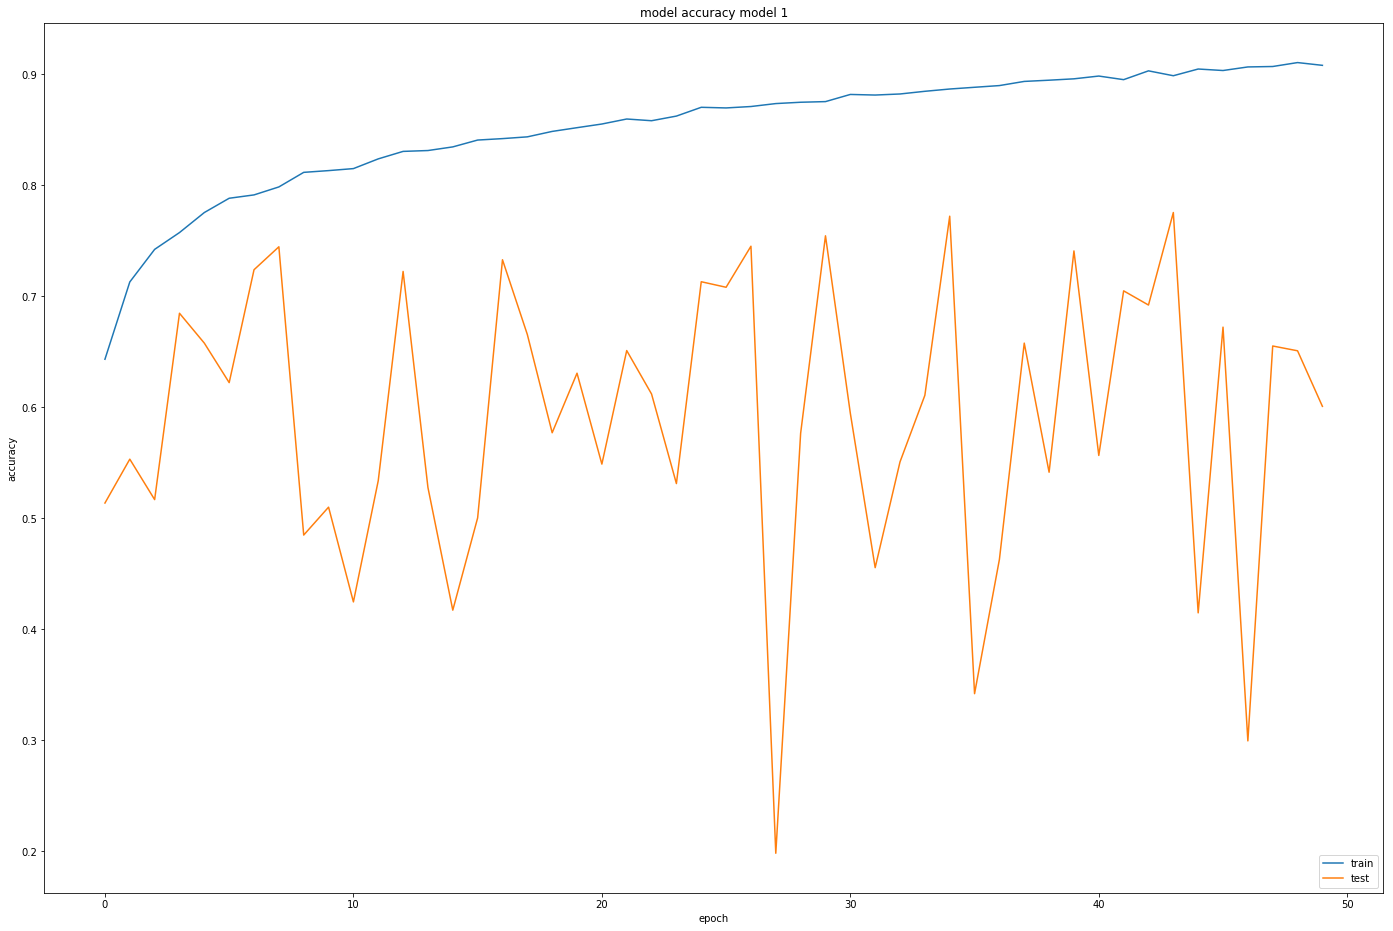

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(24, 16))
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy model 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

In [12]:
def unlabelSeg(predict):
    # Takes predicted outputs and makes a best guess at what the class would be given the probabilities
    output = predict
    for i in range(len(output[:])):
        for j in range(len(output[i,:])):
            for k in range(len(output[i, j, :])):
                m = max(output[i, j, k,:])
                output[i,j,k,:] = np.where(np.where(output[i,j,k,:] < .05, 0, output[i,j,k,:] ) == m, 1, 0)
    return output

def ConvertRGB(data, sample):
    # Used in plotting model results and input data
    # Converts the labels to their corresponding RGB color
    if len(data) == len(sample):
        output = data
    else:
        output = data[sample]
        
    Dims = len(sample)
    newArray = np.zeros((Dims,360,480,3))
    
    Sky = [128,128,128]
    Skylab = [1,0,0,0,0,0,0,0,0,0,0,0]
    Building = [128,0,0]
    Buildinglab = [0,1,0,0,0,0,0,0,0,0,0,0]
    Pole = [192,192,128]
    Polelab = [0,0,1,0,0,0,0,0,0,0,0,0]
    Road_marking = [255,69,0]
    RoadMarklab = [0,0,0,1,0,0,0,0,0,0,0,0]
    Road = [128,64,128]
    Roadlab = [0,0,0,0,1,0,0,0,0,0,0,0]
    Pavement = [60,40,222]
    Pavementlab = [0,0,0,0,0,1,0,0,0,0,0,0]
    Tree = [128,128,0]
    Treelab = [0,0,0,0,0,0,1,0,0,0,0,0]
    SignSymbol = [192,128,128]
    Signlab = [0,0,0,0,0,0,0,1,0,0,0,0]
    Fence = [64,64,128]
    Fencelab = [0,0,0,0,0,0,0,0,1,0,0,0]
    Car = [64,0,128]
    Carlab = [0,0,0,0,0,0,0,0,0,1,0,0]
    Pedestrian = [64,64,0]
    Pedestrianlab = [0,0,0,0,0,0,0,0,0,0,1,0]
    Bicyclist = [0,128,192]
    Bicyclistlab = [0,0,0,0,0,0,0,0,0,0,0,1]
    Unlabelled = [0,0,0]
    Unlab = [0,0,0,0,0,0,0,0,0,0,0,0]

    for i in range(len(output[:])):
        for j in range(len(output[i,:])):
            for k in range(len(output[i, j, :])):
                if False not in (output[i, j, k,:]== Skylab):
                    newArray[i,j,k,:] = Sky
                elif False not in (output[i,j,k,:]== Buildinglab):
                    newArray[i,j,k,:] = Building
                elif False not in (output[i,j,k,:]== Polelab):
                    newArray[i,j,k,:] = Pole
                elif False not in (output[i,j,k,:]== RoadMarklab):
                    newArray[i,j,k,:] = Road_marking
                elif False not in (output[i,j,k,:]== Roadlab):
                    newArray[i,j,k,:] = Road
                elif False not in (output[i,j,k,:]== Pavementlab):
                    newArray[i,j,k,:] = Pavement
                elif False not in (output[i,j,k,:]== Treelab):
                    newArray[i,j,k,:] = Tree
                elif False not in (output[i,j,k,:]== Signlab):
                    newArray[i,j,k,:] = SignSymbol
                elif False not in (output[i,j,k,:]== Fencelab):
                    newArray[i,j,k,:] = Fence
                elif False not in (output[i,j,k,:]== Carlab):
                    newArray[i,j,k,:] = Car
                elif False not in (output[i,j,k,:]== Pedestrianlab):
                    newArray[i,j,k,:] = Pedestrian
                elif False not in (output[i,j,k,:]== Bicyclistlab):
                    newArray[i,j,k,:] = Bicyclist
                else:
                    newArray[i,j,k,:] = Unlabelled
                    
    return newArray
                
            

In [13]:
sample = np.random.randint(0,test_data.shape[0], 4)
predict = G.predict(test_data[sample])
predict = unlabelSeg(predict)
rgbPred = ConvertRGB(predict, sample)
rgbTest = ConvertRGB(test_label, sample)

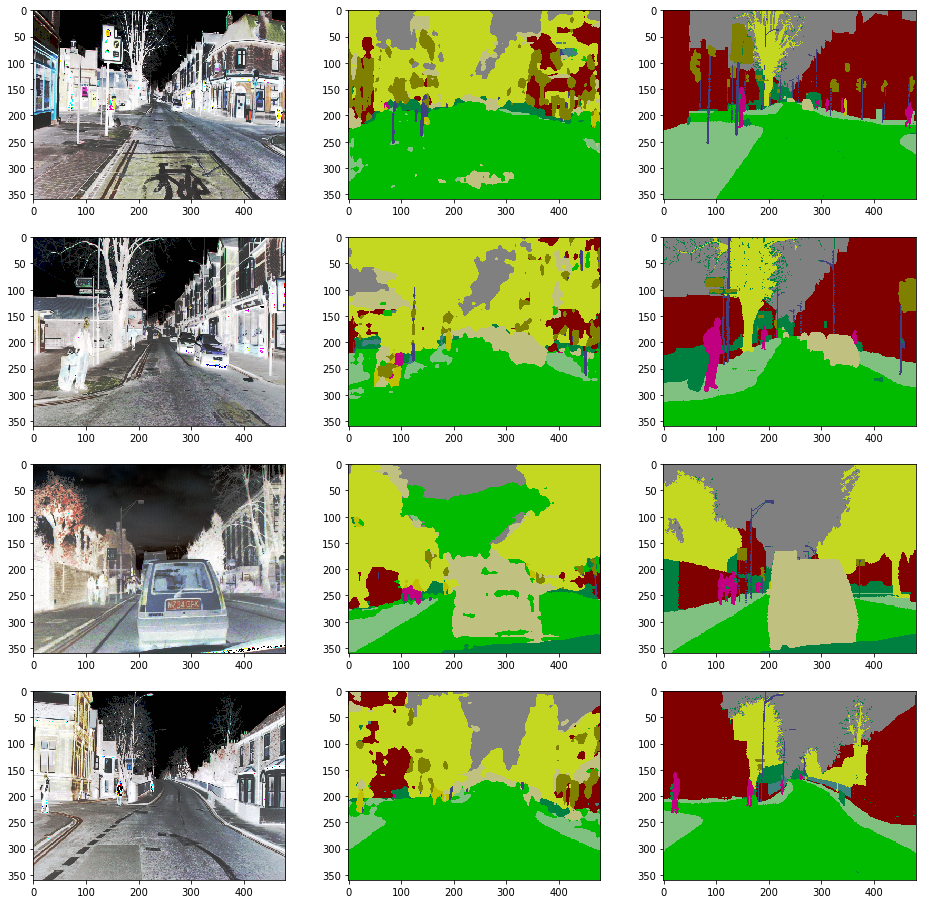

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(16, 16))


plt.subplot(4,3,1)  
plt.imshow(test_data[sample][0])
plt.subplot(4,3,2)  
plt.imshow(rgbPred[0])
plt.subplot(4,3,3)  
plt.imshow(rgbTest[0])

plt.subplot(4,3,4)  
plt.imshow(test_data[sample][1])
plt.subplot(4,3,5)  
plt.imshow(rgbPred[1])
plt.subplot(4,3,6)  
plt.imshow(rgbTest[1])

plt.subplot(4,3,7)  
plt.imshow(test_data[sample][2])
plt.subplot(4,3,8)  
plt.imshow(rgbPred[2])
plt.subplot(4,3,9)  
plt.imshow(rgbTest[2])

plt.subplot(4,3,10)  
plt.imshow(test_data[sample][3])
plt.subplot(4,3,11)  
plt.imshow(rgbPred[3])
plt.subplot(4,3,12)  
plt.imshow(rgbTest[3])